# Hugging Face BPE Tokenizer
https://github.com/huggingface/tokenizers/tree/master/bindings/python

In [3]:
files = ["./data/정치.csv"]
modelname = "bpe_20200319"

In [9]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors

# Initialize a tokenizer
tokenizer = Tokenizer(models.BPE.empty())

# Customize pre-tokenization and decoding
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
tokenizer.decoder = decoders.ByteLevel()
tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)

# And then train
trainer = trainers.BpeTrainer(vocab_size=20000, min_frequency=2)
tokenizer.train(trainer, modelname)

# Now we can encode
encoded = tokenizer.encode('자유한국당한국당예비후보때문에가능성국민들미래통합당필리버스터험지출마')
print(encoded)

AttributeError: module 'tokenizers.processors' has no attribute 'ByteLevel'

## 학습용 파일 읽기

In [3]:
import pandas as pd
contents = []

for file in files :
    df = pd.read_csv(file)
    contents = contents + df["content"].tolist()

len(contents)

356435

---

## 1. Word Piece Model (WPM)

### 1) WPM 학습

In [10]:
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer()
tokenizer.train(files)
tokenizer.save("./model/wpm/", modelname)

['./model/wpm/bpe_20200319-vocab.txt']

In [4]:
from tokenizers import BertWordPieceTokenizer

# Load a BPE Model
vocab = "./model/wpm/{}-vocab.txt".format(modelname)
tokenizer = BertWordPieceTokenizer(vocab)

In [5]:
import pandas as pd

file = open("./model/wpm/bpe_20200319-vocab.txt", 'r') 
vocabs = file.read().split('\n')



In [41]:
len(str('정치'))

5

In [6]:
vocabs = [vocab for vocab in vocabs if  ("#" not in vocab)]
[(vocab, len(vocab)) for vocab in vocabs if  (len(vocab)>1)]

[('[PAD]', 5),
 ('[UNK]', 5),
 ('[CLS]', 5),
 ('[SEP]', 5),
 ('[MASK]', 6),
 ('이', 2),
 ('정', 3),
 ('대', 2),
 ('기', 2),
 ('20', 2),
 ('거', 2),
 ('지', 2),
 ('오', 2),
 ('국', 3),
 ('전', 3),
 ('한', 3),
 ('아', 2),
 ('그', 2),
 ('주', 2),
 ('바', 2),
 ('정치', 5),
 ('의', 2),
 ('고', 2),
 ('사', 2),
 ('시', 2),
 ('것', 3),
 ('위', 2),
 ('해', 2),
 ('보', 2),
 ('가', 2),
 ('수', 2),
 ('하', 2),
 ('co', 2),
 ('서', 2),
 ('공', 3),
 ('과', 2),
 ('있다', 5),
 ('미', 2),
 ('2020', 4),
 ('우', 2),
 ('어', 2),
 ('re', 2),
 ('sid', 3),
 ('flash', 5),
 ('추', 2),
 ('자', 2),
 ('있', 3),
 ('김', 3),
 ('화', 2),
 ('제', 2),
 ('조', 2),
 ('저', 2),
 ('경', 3),
 ('일', 3),
 ('비', 2),
 ('news', 4),
 ('com', 3),
 ('문', 3),
 ('노', 2),
 ('중', 3),
 ('연', 3),
 ('2019', 4),
 ('기자', 4),
 ('마', 2),
 ('여', 2),
 ('나', 2),
 ('무', 2),
 ('등', 3),
 ('03', 2),
 ('국회', 5),
 ('의원', 5),
 ('관', 3),
 ('서울', 5),
 ('부', 2),
 ('구', 2),
 ('유', 2),
 ('재', 2),
 ('당', 3),
 ('ᄋ

### 2) WPM 활용 토큰화

In [15]:
# Multiprocessing 으로 변경
import re
import numpy as np

def tokenizeBySplit(contents) :
    hangul = re.compile('[^ \u3131-\u3163\uac00-\ud7a3]+')

    tokenized_text = []
    cnt = 1

    for content in contents :
        try :
            if content == np.nan :
                continue 
                
            text = hangul.sub('', content)
            tokenized_text = tokenized_text + [w for w in tokenizer.encode(text).tokens if len(w) > 1]

            cnt += 1
            if cnt % 1000 == 0 : 
                print("{} / {}".format(cnt, len(contents)))
        except Exception as e:
            continue
            #print(str(e))
            #print(content)
            
    return tokenized_text

import multiprocessing

def tokenize(contents) :
    chunk_size = int(len(contents)/multiprocessing.cpu_count())-3
    li_split = [contents[i:i + chunk_size] for i in range(0, len(contents), chunk_size)]
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    ret = pool.map(tokenizeBySplit, li_split)
    
    tokenized_text = []
    for text in ret :
        #print(text)
        tokenized_text = tokenized_text + [token.replace("##","").replace("▁","") for token in text if (token not in ('[CLS]','[SEP]','[UNK]')) & (len(token.replace("##",""))>1)]
    
    return tokenized_text

tokenized_text = tokenize(contents[:100])

In [16]:
tokenized_text[0]

'동영상'

### 3) 토큰 분포 확인

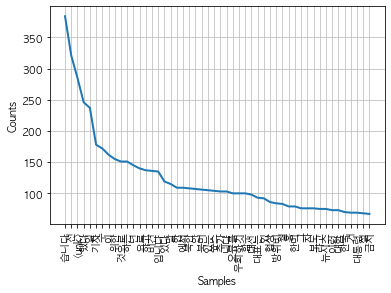

In [21]:
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

def calFreqDist(tokenized_text) :
    fdist=FreqDist(tokenized_text)
    rc('font', family='AppleGothic')
    fdist.plot(50)
    return fdist

fdist = calFreqDist(tokenized_text)

In [22]:
len(tokenized_text)

38580

In [23]:
fdist.most_common(100)

[('습니다', 384),
 ('전', 321),
 ('<unk>', 285),
 ('했다', 246),
 ('일', 237),
 ('기자', 178),
 ('수', 172),
 ('이', 162),
 ('위한', 155),
 ('것으로', 151),
 ('하는', 151),
 ('년', 145),
 ('으로', 140),
 ('하고', 137),
 ('비건', 136),
 ('입니다', 135),
 ('있다', 119),
 ('말', 115),
 ('한', 109),
 ('에서', 109),
 ('북한', 108),
 ('안', 107),
 ('북미', 106),
 ('있는', 105),
 ('뉴스', 104),
 ('추가', 103),
 ('니다', 103),
 ('오류를', 100),
 ('우회하기', 100),
 ('함수', 100),
 ('대선', 98),
 ('대표는', 93),
 ('있', 92),
 ('협상', 86),
 ('방위비', 84),
 ('월', 83),
 ('홍', 79),
 ('한미', 79),
 ('그', 76),
 ('차', 76),
 ('보도', 76),
 ('라고', 75),
 ('뉴시스', 75),
 ('이런', 73),
 ('대한', 73),
 ('한국', 70),
 ('거', 69),
 ('대통령', 69),
 ('설', 68),
 ('금지', 67),
 ('분담금', 67),
 ('억', 67),
 ('위해', 66),
 ('것이', 66),
 ('미국', 64),
 ('연합뉴스', 63),
 ('한다', 63),
 ('이라고', 63),
 ('우리', 62),
 ('것', 62),
 ('통해', 62),
 ('두', 61),
 ('더', 61),
 ('하지', 61),
 ('서울', 61),
 ('김', 61),
 ('주장', 61),
 ('할', 59),
 ('및', 59),
 ('등', 58),
 ('김경수', 56),
 ('채널', 56),
 ('대표', 55),
 ('앵커', 54),
 ('에는', 54),


In [24]:
from konlpy.tag import Mecab
import pandas as pd

def genVoab(fdist, name) :
    mecab = Mecab()
    vocab = []

    for w in fdist.most_common(10000) :
        pos = mecab.pos(w[0])
        if (pos[0][1][0] == "N") & (len(pos[0][0]) > 1) & (len(pos)>1) & (w[1]>100):
            m = str(pos)
            b = "".join([p[0] for p in pos])
            p = ",".join([p[1] for p in pos])
            f = w[1]
            #print(str(pos) + " " + str(w[1]) + " " + str(b))
            vocab.append((m,p,b,f))

    return pd.DataFrame(vocab, columns=['Mecab', 'PoS', name, 'Freq'])

df = genVoab(fdist, "WPM")
df.to_csv("./dict_wpm.csv")
df.head(50)        

,Mecab,PoS,WPM,Freq


---

## Sentence Piece Model (SPM)

In [9]:
from tokenizers import SentencePieceBPETokenizer
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(files)
tokenizer.save("./model/spm/", modelname)

['./model/spm/bpe_20200319-vocab.json', './model/spm/bpe_20200319-merges.txt']

In [17]:
from tokenizers import SentencePieceBPETokenizer

# Load a BPE Model
vocab = "./model/spm/{}-vocab.json".format(modelname)
merges = "./model/spm/{}-merges.txt".format(modelname)
tokenizer = SentencePieceBPETokenizer(vocab, merges)

In [18]:
tokenized_text = tokenize(contents[:100])

In [19]:
tokenized_text

['동영상',
 '뉴스',
 '오류를',
 '우회하기',
 '위한',
 '함수',
 '추가',
 '앵커',
 '비하',
 '뉴스',
 '시작',
 '하겠',
 '습니다',
 '안',
 '지현',
 '기자',
 '첫',
 '번째',
 '키워드',
 '볼',
 '기자',
 '첫',
 '키워드는',
 '누',
 '생일',
 '입',
 '니다',
 '앵커',
 '해피',
 '버스',
 '데이',
 '누구',
 '생일',
 '니까',
 '기자',
 '어',
 '제가',
 '박근혜',
 '전',
 '대통령의',
 '생일',
 '이었',
 '습니다',
 '그런데',
 '정치권에서는',
 '한국당',
 '한선교',
 '의원이',
 '이를',
 '공개',
 '언급',
 '습니다',
 '한',
 '의원은',
 '생일',
 '당일',
 '어제',
 '페이스북에',
 '글을',
 '올렸',
 '는데',
 '보시는',
 '것처럼',
 '번째',
 '생',
 '신이',
 '이렇게',
 '얘기를',
 '했고',
 '그리고',
 '박',
 '전',
 '대통령을',
 '가리',
 '우리',
 '세대',
 '에게는',
 '늘',
 '영',
 '누',
 '이렇게',
 '얘기',
 '습니다',
 '또',
 '뒤에',
 '보시',
 '올해',
 '생',
 '구치',
 '소에서',
 '보내',
 '시는',
 '마음이',
 '아프',
 '이렇게',
 '안타까',
 '움을',
 '표현',
 '하기도',
 '했',
 '습니다',
 '앵커',
 '여기서',
 '이제',
 '누',
 '생일',
 '이라는',
 '키워드',
 '나온',
 '거',
 '그런데',
 '한선교',
 '의원이',
 '이렇게',
 '발언을',
 '한',
 '이유가',
 '있',
 '습니까',
 '기자',
 '일단',
 '한선교',
 '의원은',
 '박',
 '전',
 '대통령의',
 '친',
 '동생',
 '박',
 '지만',
 '회장과',
 '친구',
 '사',
 '이고',
 '그래서',
 '실제로',
 '박',
 '전',
 '대통령

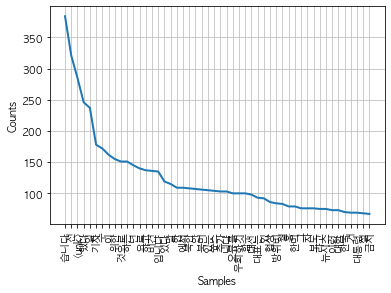

In [25]:
fdist = calFreqDist(tokenized_text)

In [26]:
df = genVoab(fdist, "SPM")
df.to_csv("./dict_spm.csv")
df.head(50)        

,Mecab,PoS,SPM,Freq


---

In [1]:
from konlpy.tag import Mecab
mecab = Mecab()
mecab.pos('자유한국당한국당예비후보때문에가능성국민들미래통합당필리버스터험지출마') # 사전등록후 Mecab

[('자유한국당', 'NNP'),
 ('한국당', 'NNP'),
 ('예비', 'NNG'),
 ('후보', 'NNG'),
 ('때문', 'NNB'),
 ('에', 'JKB'),
 ('가능', 'NNG'),
 ('성', 'XSN'),
 ('국민', 'NNG'),
 ('들', 'XSN'),
 ('미래통합당', 'NNP'),
 ('필리버스터', 'NNP'),
 ('험지출마', 'NNP')]

In [27]:
tokenizer.encode('자유한국당한국당예비후보때문에가능성국민들미래통합당필리버스터험지출마').tokens

['▁자유한국당',
 '한국당',
 '예비후보',
 '때',
 '문에',
 '가능',
 '성',
 '국민',
 '들',
 '미래통합당',
 '필리버스터',
 '험지',
 '출마']